In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import torch
import torchvision as tv
from torchvision import models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
model = torch.load('model.pth', map_location=torch.device('cuda'))

In [ ]:
img = cv2.imread('drone.jpg')
start = time.time()
img_tensor = T.ToTensor()(img)
output = model([img_tensor.to(torch.device('cuda'))])
end = time.time()
print(end - start)

0.04546356201171875


In [ ]:
model.parameters()

<generator object Module.parameters at 0x7b845b6c0580>

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="1dWHLhUPvO86N3OT1U1h")
project = rf.workspace("2-kendaraan-tia").project("helikopter-done")
version = project.version(1)
dataset = version.download("voc")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to helikopter-done-1 in voc:: 100%|██████████| 3771/3771 [00:00<00:00, 6921.08it/s]


In [ ]:
rf = Roboflow(api_key="1dWHLhUPvO86N3OT1U1h")
project = rf.workspace("class-gvtg0").project("planes-hbii1")
version = project.version(1)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Planes-1 in voc:: 100%|██████████| 19805/19805 [00:04<00:00, 4396.91it/s]


In [ ]:
rf = Roboflow(api_key="1dWHLhUPvO86N3OT1U1h")
project = rf.workspace("military-drone").project("drone_mil-u8fqk")
version = project.version(1)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to drone_mil-1 in voc:: 100%|██████████| 14527/14527 [00:07<00:00, 1854.86it/s]


In [ ]:
rf = Roboflow(api_key="1dWHLhUPvO86N3OT1U1h")
project = rf.workspace("birddetecitonavisent").project("bird-detection-kzmpu")
version = project.version(2)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bird-detection-2 in voc:: 100%|██████████| 28313/28313 [00:10<00:00, 2718.48it/s]


In [ ]:
# make datasets' destribution 70% train, 20% valid, 10% test
# drone and plane datasets are OK
# for helicopter dataset:
import shutil
import os
from random import sample

valid = os.listdir("helikopter-done-1/valid/")
test =  os.listdir("helikopter-done-1/test/")
train = os.listdir("helikopter-done-1/train/")
all = valid + test + train
print(len(all))
test_percent = len(test) / len(all)
print(test_percent)
for file in train:
  if test_percent < 0.1:
    file_name = os.path.join("helikopter-done-1/train/", file)
    shutil.move(file_name, "helikopter-done-1/test/")
    if file_name.endswith('jpg'):
            file_name = file_name[:-3]
            file_name += 'xml'
            shutil.move(file_name, "helikopter-done-1/test/")
    else:
            file_name = file_name[:-3]
            file_name += 'jpg'
            shutil.move(file_name, "helikopter-done-1/test/")
    test =  os.listdir("helikopter-done-1/test/")
    test_percent = len(test) / len(all)
  else:
    break

3766
0.10037174721189591


In [ ]:
test =  os.listdir("helikopter-done-1/test/")
print(len(test)/2)

189.0


In [ ]:
train = os.listdir("helikopter-done-1/train/")
print(len(train)/2)

1336.0


In [ ]:
valid = os.listdir("helikopter-done-1/valid/")
print(len(valid)/2)

358.0


In [ ]:
# for birds dataset:

valid = os.listdir("bird-detection-2/valid/")
test =  os.listdir("bird-detection-2/test/")
train = os.listdir("bird-detection-2/train/")
all = valid + test + train
print(len(all))
test_percent = len(test) / len(all)
valid_percent = len(valid) / len(all)
print(test_percent)
for file in train:
  if test_percent < 0.1:
    file_name = os.path.join("bird-detection-2/train/", file)
    shutil.move(file_name, "bird-detection-2/test/")
    if file_name.endswith('jpg'):
            file_name = file_name[:-3]
            file_name += 'xml'
            shutil.move(file_name, "bird-detection-2/test/")
    elif file_name.endswith('xml'):
            file_name = file_name[:-3]
            file_name += 'jpg'
            shutil.move(file_name, "bird-detection-2/test/")
    test =  os.listdir("bird-detection-2/test/")
    test_percent = len(test) / len(all)
  elif valid_percent < 0.2:
    file_name = os.path.join("bird-detection-2/train/", file)
    shutil.move(file_name, "bird-detection-2/valid/")
    if file_name.endswith('jpg'):
            file_name = file_name[:-3]
            file_name += 'xml'
            shutil.move(file_name, "bird-detection-2/valid/")
    elif file_name.endswith('xml'):
            file_name = file_name[:-3]
            file_name += 'jpg'
            shutil.move(file_name, "bird-detection-2/valid/")
    valid =  os.listdir("bird-detection-2/valid/")
    valid_percent = len(valid) / len(all)
  else:
    break

28308
0.055814610710753144


Error: Destination path 'bird-detection-2/test/Brewer_Sparrow_0001_796718_jpg.rf.eef65a35e27d4adde078b4ccd5914bb4.xml' already exists

In [ ]:
print(len(test)/2)
print(len(valid)/2)
print(len(train)/2)

189.0
358.0
1336.0


In [ ]:
import shutil
shutil.rmtree("bird-detection-2")
shutil.rmtree("drone_mil-1")
shutil.rmtree("helikopter-done-1")
shutil.rmtree("Planes-1")
shutil.rmtree("dataset")

In [ ]:
!mkdir dataset
!mkdir dataset/valid
!mkdir dataset/test
!mkdir dataset/train

In [ ]:
import glob
import os
import shutil

folders = ["drone_mil-1/", "Planes-1/", "helikopter-done-1/", "bird-detection-2/"]
subfolders = ["valid/", "test/", "train/"]

for fl in folders:
  for sbfl in subfolders:
    num_files = 0
    if sbfl == "valid/":
      n = 100
    elif sbfl == "test/":
      n = 50
    elif sbfl == "train/":
      n = 500
    for f in glob.glob(fl + sbfl + '*.xml'):
        if num_files < n:
          shutil.move(f, 'dataset/' + sbfl)
          f = f[:-3]
          f += 'jpg'
          shutil.move(f, 'dataset/' + sbfl)
          num_files += 1
        else:
          break

In [ ]:
len(glob.glob('dataset/train/*.jpg'))

2000

In [ ]:
folders = ["drone_mil-1/", "Planes-1/", "helikopter-done-1/", "bird-detection-2/"]
subfolders = ["valid/", "test/", "train/"]

for fl in folders:
  for sbfl in subfolders:
    # Define the source and destination path
    source = fl + sbfl
    destination = "dataset/"
    n = 0
    if sbfl == "valid/":
      n = 550
    elif sbfl == "test/":
      n = 300
    elif sbfl == "train/":
      n = 2000
    # code to move the files from sub-folder to main folder.
    files = os.listdir(source)
    if fl != "helikopter-done-1/":
      for file in files[:n]:
          file_name = os.path.join(source, file)
          shutil.move(file_name, destination + sbfl)
          if file_name.endswith('jpg'):
            file_name = file_name[:-3]
            file_name += 'xml'
            shutil.move(file_name, destination + sbfl)
          elif file_name.endswith('xml'):
            file_name = file_name[:-3]
            file_name += 'jpg'
            shutil.move(file_name, destination + sbfl)
    else:
      for file in files:
        file_name = os.path.join(source, file)
        shutil.move(file_name, destination + sbfl)

In [ ]:
valid = os.listdir("dataset/valid/")
test =  os.listdir("dataset/test/")
train = os.listdir("dataset/train/")
print(len(valid)/2)
print(len(test)/2)
print(len(train)/2)

400.0
200.0
2000.0


In [ ]:
!python xml_to_csv.py

Successfully converted xml to csv.


In [ ]:
df = pd.read_csv('dataset/train/_labels.csv')

In [ ]:
df.loc[df['class'] == 'helikopter', 'class'] = 'helicopter'

In [ ]:
df.loc[(df['class'] != 'helicopter') & (df['class'] != 'drone') & (df['class'] != 'bird'), 'class'] = 'airplane'

In [ ]:
df[df.duplicated(['filename'])]

,filename,width,height,class,xmin,ymin,xmax,ymax
18,burung-35-_jpg.rf.1e10a44d5f32bdc542a22011cdf8...,640,640,bird,382,501,289,355
23,13_png.rf.1c90d5b7095f71c58fd53893d69ddd4a.jpg,640,640,bird,304,512,297,470
25,422_jpg.rf.d0f4629c32e7bc6a6c8e47a13f3ab2b7.jpg,640,640,bird,90,237,389,620
41,3d014430fdb5aa6c5bcf652a58db582b_jpg.rf.1344e1...,640,640,airplane,406,438,190,211
49,7dd3ee3581d1bfcae6a393ca5677a8b9_jpg.rf.288285...,640,640,airplane,140,249,188,353
...,...,...,...,...,...,...,...,...
2878,Egyptian-Mi-24-AH-64-Ka-52-and-CH-47-helicopte...,640,640,helicopter,119,219,219,315
2879,Egyptian-Mi-24-AH-64-Ka-52-and-CH-47-helicopte...,640,640,helicopter,463,560,218,316
2891,Egyptian-Mi-24-AH-64-Ka-52-and-CH-47-helicopte...,640,640,helicopter,469,554,228,322
2914,00000656_jpg.rf.47f423530a87410241706c9e1c9d05...,640,640,helicopter,449,563,236,432


In [ ]:
#airplane : 1
#drone : 2
#helicopter : 3
#bird : 4

In [ ]:
df.loc[df['class'] == 'airplane', 'class'] = 1
df.loc[df['class'] == 'drone', 'class'] = 2
df.loc[df['class'] == 'helicopter', 'class'] = 3
df.loc[df['class'] == 'bird', 'class'] = 4

In [ ]:
df[(df['xmin'] == df['ymax'])]

,filename,width,height,class,xmin,ymin,xmax,ymax
382,94a38dc0f8440c8249d7ec31d3a8a99a_jpg.rf.7a80e3...,640,640,1,317,358,225,317
488,7afa0fba6c46256ba589779d701ad9c3_jpg.rf.4bd926...,640,640,1,236,621,69,236
2184,Egyptian-Mi-24-AH-64-Ka-52-and-CH-47-helicopte...,640,640,3,336,459,236,336
2636,00000636_jpg.rf.52c381e9146d6cfa468ee9edcaa6c2...,640,640,3,400,505,304,400


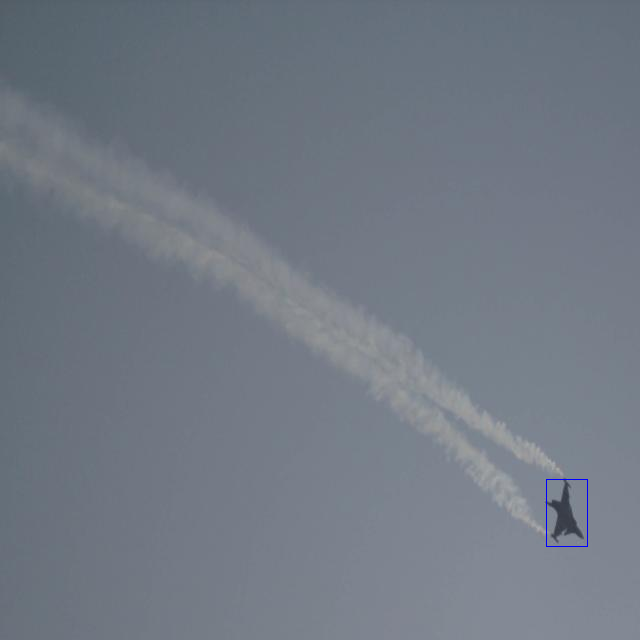

In [ ]:
image_name = glob.glob('dataset/train/46a6dbccbfb976bf51cc6184f03272d4_jpg.rf.03fb6744ee4aad4d494efdd8044d5a46.jpg')[0]
img = cv2.imread(image_name)
cv2.rectangle(img, (546, 479), (587, 546), (255, 0, 0))
cv2_imshow(img)

In [ ]:
cols = list(df.columns)
a, b = cols.index('ymin'), cols.index('xmax')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

In [ ]:
df = df.rename(columns={'xmax': 'ymin', 'ymin': 'xmax'})

In [ ]:
df = df[(df['ymin'] != df['ymax']) & (df['xmin'] != df['xmax'])]

In [ ]:
df.loc[df['class'] == 1]

,filename,width,height,class,xmin,ymin,xmax,ymax
2,a19782944265ea3a6b62eb9a529379e2_jpg.rf.7da66d...,640,640,1,184,199,479,345
9,8487027f382267a5a98c87338c60eda0_jpg.rf.4a782a...,640,640,1,1,2,622,491
12,e337e59101e56e23fd3ec86e48392afd_jpg.rf.3ea954...,640,640,1,16,55,609,594
16,58a951513ee0bfcceb4431ef799e2f60_jpg.rf.6c04ac...,640,640,1,2,5,641,593
21,7a050e1bf398f5a56b99108ffe7d5106_jpg.rf.113fc2...,640,640,1,2,2,641,214
...,...,...,...,...,...,...,...,...
2175,50383ae26576f1a80c2b417d6db4cc05_jpg.rf.c7f85d...,640,640,1,293,372,306,407
2176,deb88d0db0e3aee9dc80e8b8a5d26d45_jpg.rf.b39b07...,640,640,1,308,3,613,411
2186,b0cad1e678091719aece6331710252e3_jpg.rf.ca3c22...,640,640,1,38,66,607,556
2188,3bd1a485d1ce7375e0057fbb79b81dc4_jpg.rf.09c49c...,640,640,1,64,270,580,554


In [ ]:
df.loc[df['ymax'] >= 640, 'ymax'] = 639

In [ ]:
df.loc[df['xmax'] >= 640, 'xmax'] = 639

In [ ]:
df.to_csv('dataset/train/_labels.csv', index=False)

In [ ]:
df = pd.read_csv('dataset/train/_labels.csv')

In [ ]:
df[df['ymin'] == df['ymax']] #543, 302, 583, 366

,filename,width,height,class,xmin,ymin,xmax,ymax


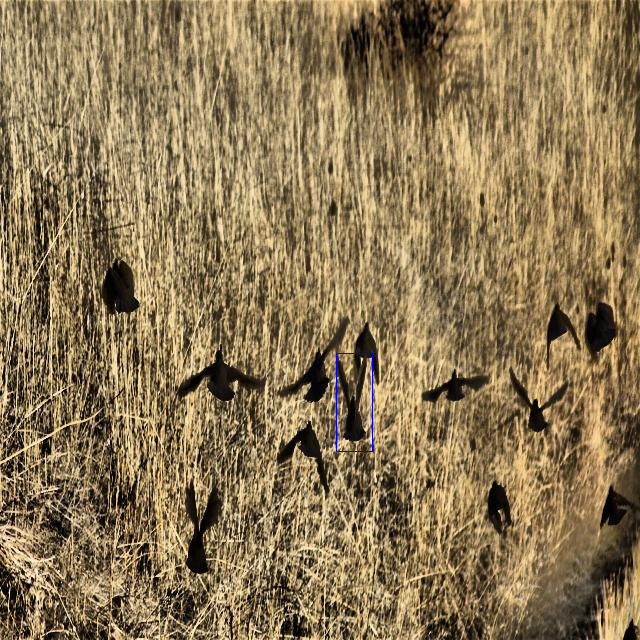

In [ ]:
image_name = glob.glob('dataset/train/MG_1304_jpg.rf.2306c19e60807b2875019077160e4774.jpg')[0]
img = cv2.imread(image_name)
cv2.rectangle(img, (336, 353), (372, 451), (255, 0, 0))
cv2_imshow(img)


In [ ]:
class AircraftDataset(Dataset):
  def __init__ (self, csv_file, root_dir, transform=None):
    self.aircraft_df = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.aircraft_df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.aircraft_df.iloc[idx, 0])
    image = cv2.imread(img_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    aircrafts = self.aircraft_df.iloc[idx]
    labels = np.array([], dtype=np.int64)
    dublicates = self.aircraft_df[self.aircraft_df['filename'] == self.aircraft_df.iloc[idx][0]].to_numpy()
    aircrafts = np.array([], dtype=np.int64).reshape(-1, 4)
    for row in dublicates:
      labels = np.append(labels, [row[3]])
      aircrafts = np.append(aircrafts, [row[4:]], axis=0)
    tmp_boxes = aircrafts
    aircrafts = torch.tensor(aircrafts.tolist())
    labels = torch.tensor(labels.tolist(), dtype=torch.long)
    sample = {'labels': labels, 'bboxes': aircrafts}

    if self.transform:
        sample = self.transform(sample)

    return T.ToTensor()(image), sample

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def custom_collate(data):
  return data

In [ ]:
aircraft_dataset = AircraftDataset(csv_file='dataset/train/_labels.csv',
                                    root_dir='dataset/train/')
batch_size = 4
dataloader = DataLoader(aircraft_dataset, batch_size=batch_size,
                        shuffle=True, collate_fn=custom_collate, num_workers=2)

ValueError: not enough values to unpack (expected 4, got 2)

<Figure size 640x480 with 0 Axes>

In [ ]:


val_ds = AircraftDataset(csv_file='dataset/valid/_labels.csv',
                                    root_dir='dataset/valid/')

dataloader_val = DataLoader(val_ds, batch_size=batch_size,
                        shuffle=True, collate_fn=custom_collate, num_workers=2)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.to_csv('dataset/train/_labels.csv', index=False)

In [ ]:
for data in dataloader_val:
  for d in data:
     print(d[1]['bboxes'])
  break

tensor([[ 35,  53, 603, 482]])
tensor([[414, 205, 542, 315],
        [ 67, 241, 196, 328]])
tensor([[  2, 465,  57, 608],
        [ 38, 431, 144, 557],
        [ 94, 407, 224, 503],
        [206, 404, 336, 501],
        [323, 408, 458, 496],
        [433, 405, 568, 492],
        [548, 399, 639, 480],
        [529, 315, 639, 395],
        [404, 312, 542, 392],
        [275, 311, 410, 393],
        [162, 303, 290, 396],
        [  2, 252, 106, 333],
        [ 36, 153, 173, 231],
        [ 90, 237, 216, 335],
        [212, 216, 338, 308],
        [308, 218, 434, 312],
        [408, 238, 541, 313],
        [516, 239, 639, 320]])
tensor([[114, 169, 347, 225],
        [105, 351, 607, 498]])


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import sys

In [ ]:
model = tv.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretraind=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
num_classes = 5
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
optimizer = torch.optim.SGD([{'params':model.backbone.parameters()},
                             {'params':model.roi_heads.box_predictor.parameters()}],
                             lr=0.003, momentum=0.9, nesterov=True, weight_decay=0.0005)
optimizer = torch.optim.SGD(model.rpn.parameters(),
                            lr=0.003, momentum=0.9, nesterov=True, weight_decay=0.0005)
num_epochs = 10

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
history_loss = []
history_loss_classifier =[]
history_loss_box_reg = []
history_loss_rpn_box_reg = []
history_loss_objectness = []

In [ ]:
import matplotlib.pyplot as plt

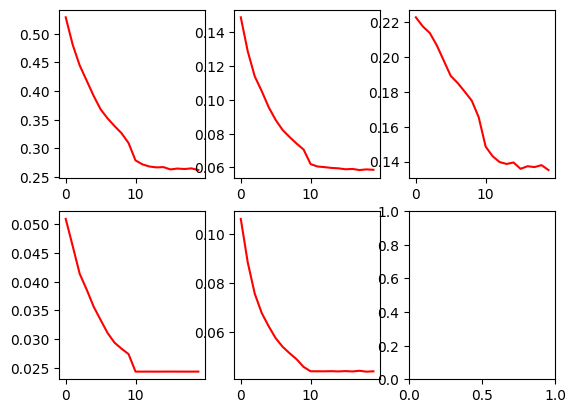

In [ ]:
figure, axis = plt.subplots(2, 3)

axis[0,0].plot(history_loss, 'r')

axis[0,1].plot(history_loss_classifier, 'r')

axis[0,2].plot(history_loss_box_reg, 'r')

axis[1,0].plot(history_loss_rpn_box_reg, 'r')

axis[1,1].plot(history_loss_objectness, 'r')
plt.show()

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for data in tqdm(loader):
        imgs = []
        targets = []
        for d in data:
          imgs.append(d[0].to(device))
          targ = {}
          boxes = tv.ops.clip_boxes_to_image(d[1]['bboxes'], [640, 640])
          targ['boxes'] = boxes.to(device)
          targ['labels'] = d[1]['labels'].to(device)
          targets.append(targ)

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    history_loss.append(np.mean(all_losses))
    history_loss_classifier.append(all_losses_dict['loss_classifier'].mean())
    history_loss_box_reg.append(all_losses_dict['loss_box_reg'].mean())
    history_loss_rpn_box_reg.append(all_losses_dict['loss_rpn_box_reg'].mean())
    history_loss_objectness.append(all_losses_dict['loss_objectness'].mean())
    print("Epoch {} (train), lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], history_loss[-1],
        history_loss_classifier[-1],
        history_loss_box_reg[-1],
        history_loss_rpn_box_reg[-1],
        history_loss_objectness[-1]
    ))

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dataloader, device, epoch)

100%|██████████| 729/729 [02:14<00:00,  5.43it/s]


Epoch 0 (train), lr: 0.003000, loss: 0.278842, loss_classifier: 0.062011, loss_box: 0.148562, loss_rpn_box: 0.024324, loss_object: 0.043945


100%|██████████| 729/729 [02:16<00:00,  5.36it/s]


Epoch 1 (train), lr: 0.003000, loss: 0.271874, loss_classifier: 0.060585, loss_box: 0.143034, loss_rpn_box: 0.024319, loss_object: 0.043937


100%|██████████| 729/729 [02:12<00:00,  5.49it/s]


Epoch 2 (train), lr: 0.003000, loss: 0.268155, loss_classifier: 0.060221, loss_box: 0.139690, loss_rpn_box: 0.024323, loss_object: 0.043921


100%|██████████| 729/729 [02:14<00:00,  5.44it/s]


Epoch 3 (train), lr: 0.003000, loss: 0.266649, loss_classifier: 0.059744, loss_box: 0.138601, loss_rpn_box: 0.024316, loss_object: 0.043989


100%|██████████| 729/729 [02:14<00:00,  5.43it/s]


Epoch 4 (train), lr: 0.003000, loss: 0.267141, loss_classifier: 0.059498, loss_box: 0.139445, loss_rpn_box: 0.024323, loss_object: 0.043875


100%|██████████| 729/729 [02:13<00:00,  5.47it/s]


Epoch 5 (train), lr: 0.003000, loss: 0.263092, loss_classifier: 0.058944, loss_box: 0.135805, loss_rpn_box: 0.024327, loss_object: 0.044017


100%|██████████| 729/729 [02:15<00:00,  5.39it/s]


Epoch 6 (train), lr: 0.003000, loss: 0.264617, loss_classifier: 0.059147, loss_box: 0.137286, loss_rpn_box: 0.024321, loss_object: 0.043863


100%|██████████| 729/729 [02:13<00:00,  5.45it/s]


Epoch 7 (train), lr: 0.003000, loss: 0.263762, loss_classifier: 0.058495, loss_box: 0.136808, loss_rpn_box: 0.024320, loss_object: 0.044140


100%|██████████| 729/729 [02:13<00:00,  5.45it/s]


Epoch 8 (train), lr: 0.003000, loss: 0.264909, loss_classifier: 0.058877, loss_box: 0.137923, loss_rpn_box: 0.024318, loss_object: 0.043792


100%|██████████| 729/729 [02:12<00:00,  5.49it/s]

Epoch 9 (train), lr: 0.003000, loss: 0.262010, loss_classifier: 0.058654, loss_box: 0.135102, loss_rpn_box: 0.024326, loss_object: 0.043929


In [ ]:
torch.save(model, 'model.pth')

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
image_name = glob.glob('dataset/test/*.jpg')[136]
#image_name = 'drone_1.jpg'
img = cv2.imread(image_name)
img = T.ToTensor()(img)
model.eval()
output = model([img.to(device)])

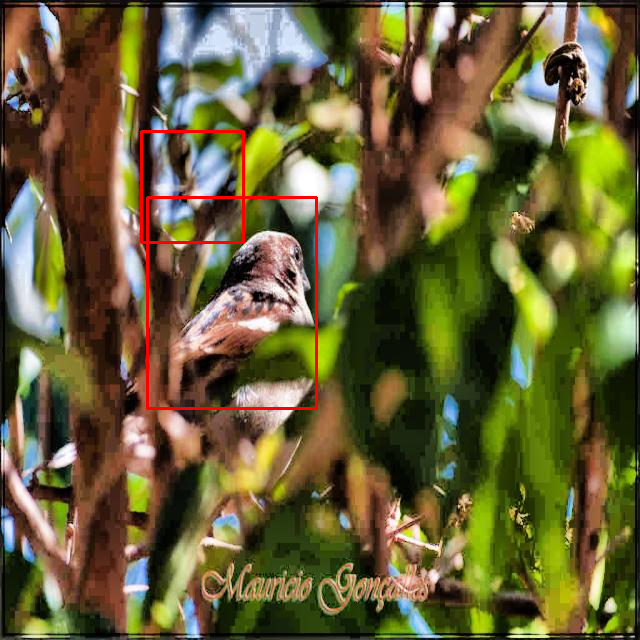

In [ ]:
img = cv2.imread(image_name)
for i in range(len(output[0]['boxes'])):
  if output[0]['scores'][i] > 0.7:
    cv2.rectangle(img, (int(output[0]['boxes'][i][0]), int(output[0]['boxes'][i][1])), (int(output[0]['boxes'][i][2]), int(output[0]['boxes'][i][3])), (0, 0, 255), 2)
cv2_imshow(img)

In [ ]:
output

[{'boxes': tensor([[147.2256, 197.5355, 316.9664, 408.0417],
          [141.5707, 131.2000, 243.9597, 242.8185],
          [541.3801,  21.6116, 603.5571, 130.7915],
          [545.9099,  23.6405, 587.6861, 139.2707],
          [160.8566, 136.6082, 194.0842, 247.9840],
          [550.5313,  36.8343, 584.6098, 125.5057]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([4, 4, 4, 1, 4, 4], device='cuda:0'),
  'scores': tensor([0.9902, 0.7337, 0.5138, 0.0990, 0.0965, 0.0540], device='cuda:0',
         grad_fn=<IndexBackward0>)}]

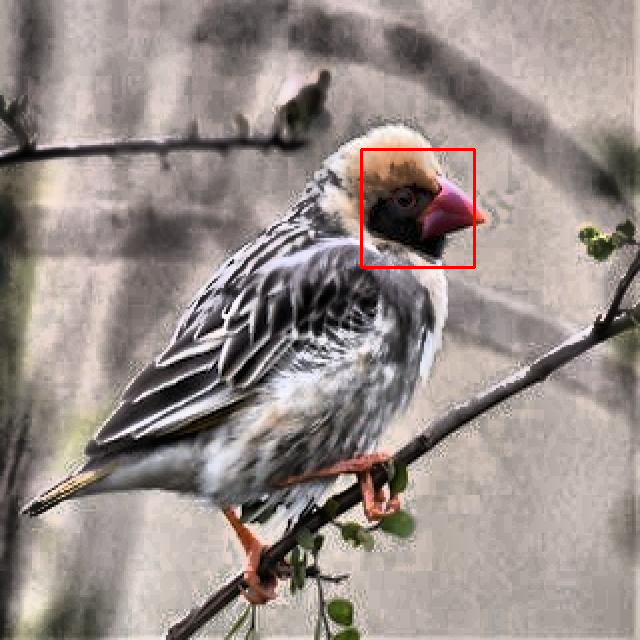

In [ ]:
img = cv2.imread(image_name)
cv2.rectangle(img, (int(output[0]['boxes'][0][0]), int(output[0]['boxes'][0][1])), (int(output[0]['boxes'][0][2]), int(output[0]['boxes'][0][3])), (0, 0, 255), 2)
cv2_imshow(img)

In [ ]:
model.to(device)
for epoch in range(num_epochs):
  epoch_loss = 0
  for data in tqdm(dataloader):
    #print(data[0][1])
    imgs = []
    targets = []
    for d in data:
      imgs.append(d[0].to(device))
      targ = {}
      targ['boxes'] = d[1]['bboxes'].to(device)
      targ['labels'] = d[1]['labels'].to(device)
      targets.append(targ)
    #print(targets[0])
    loss_dict = model(imgs, targets)
    loss = sum(v for v in loss_dict.values())
    epoch_loss += loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(epoch_loss)

NameError: name 'num_epochs' is not defined